In [1]:
import sys
sys.path.append('..')
import config as conf
import functions.notebook_helper_functions.notebook14 as funcs

paths = conf.DataFilePaths()
params = conf.ARIMA_model_parameters()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from scipy import stats
# from statistics import NormalDist

In [2]:
# Load and inspect
input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}-block_size-lag_order-difference_degree.parquet' 
data_df = pd.read_parquet(input_file)
data_df.head()

,sample,model_type,block_size,lag_order,difference_degree,moving_average_order,SMAPE_value,MBD_prediction,MBD_inputs,MBD_actual,fit_residuals,AIC,BIC,public_SMAPE,private_SMAPE
0,0,control,10,0,0,0,"[0.0014765864613563021, 0.002210738782625524, ...","[4.13237, 4.13237, 4.13237, 4.13237, 4.13237]","[4.078887, 4.0957041, 4.1109924, 4.1354532, 4....",4.124749,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,0.147659,0.221596
1,0,ARIMA,10,0,0,0,"[0.0037868857626988887, 0.007474181906130833, ...","[4.110676507159667, 4.110676507159667, 4.11067...","[4.078887, 4.0957041, 4.1109924, 4.1354532, 4....",4.124749,"[-0.031789507159666996, -0.014972407159667078,...",-20.190172,-20.971296,0.378689,0.304751
2,0,control,10,0,0,0,"[0.011049661745857784, 0.007380072898707912, 0...","[2.4454308, 2.4454308, 2.4454308, 2.4454308, 2...","[2.3156168, 2.3885496, 2.4705989, 2.4341326, 2...",2.536002,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,1.104966,3.635928
3,0,ARIMA,10,0,0,0,"[0.025286009802199163, 0.021616847605294077, 0...","[2.410860458933073, 2.410860458933073, 2.41086...","[2.3156168, 2.3885496, 2.4705989, 2.4341326, 2...",2.536002,"[-0.09524365893307296, -0.02231085893307272, 0...",-10.898335,-11.679459,2.528601,5.059004
4,0,control,10,0,0,0,"[0.0, 0.03761753866734851, 0.02523658212890990...","[2.963454, 2.963454, 2.963454, 2.963454, 2.963...","[2.9590867, 2.978116, 2.8924832, 2.9495718, 2....",3.067601,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,0.000000,2.833666


<a name="block_size"></a>
### 1. Experiment 1: block size by lag order and difference degree

In [3]:
sample_smape_scores_df = funcs.parse_results(
    input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}-block_size-lag_order-difference_degree.parquet' 
)

sample_smape_scores_df.head(3)

,sample,model_type,block_size,lag_order,difference_degree,moving_average_order,public_SMAPE,private_SMAPE,log_public_SMAPE,log_private_SMAPE
0,0,ARIMA,10,0,0,0,2.276907,3.609087,0.822818,1.283455
1,0,ARIMA,10,0,1,0,2.476320,3.947481,0.906774,1.373078
2,0,ARIMA,10,0,2,0,1.445245,6.552475,0.368279,1.879843



Winning control mean of sample SMAPE scores: 1.6959158730453254
Winning control single sample SMAPE score: 0.620667831574783

lag_order: [0, 1, 2, 3, 4]
difference_degree: [0, 1, 2, 3]
moving_average_order: [0]
block_size: [10, 20, 40]



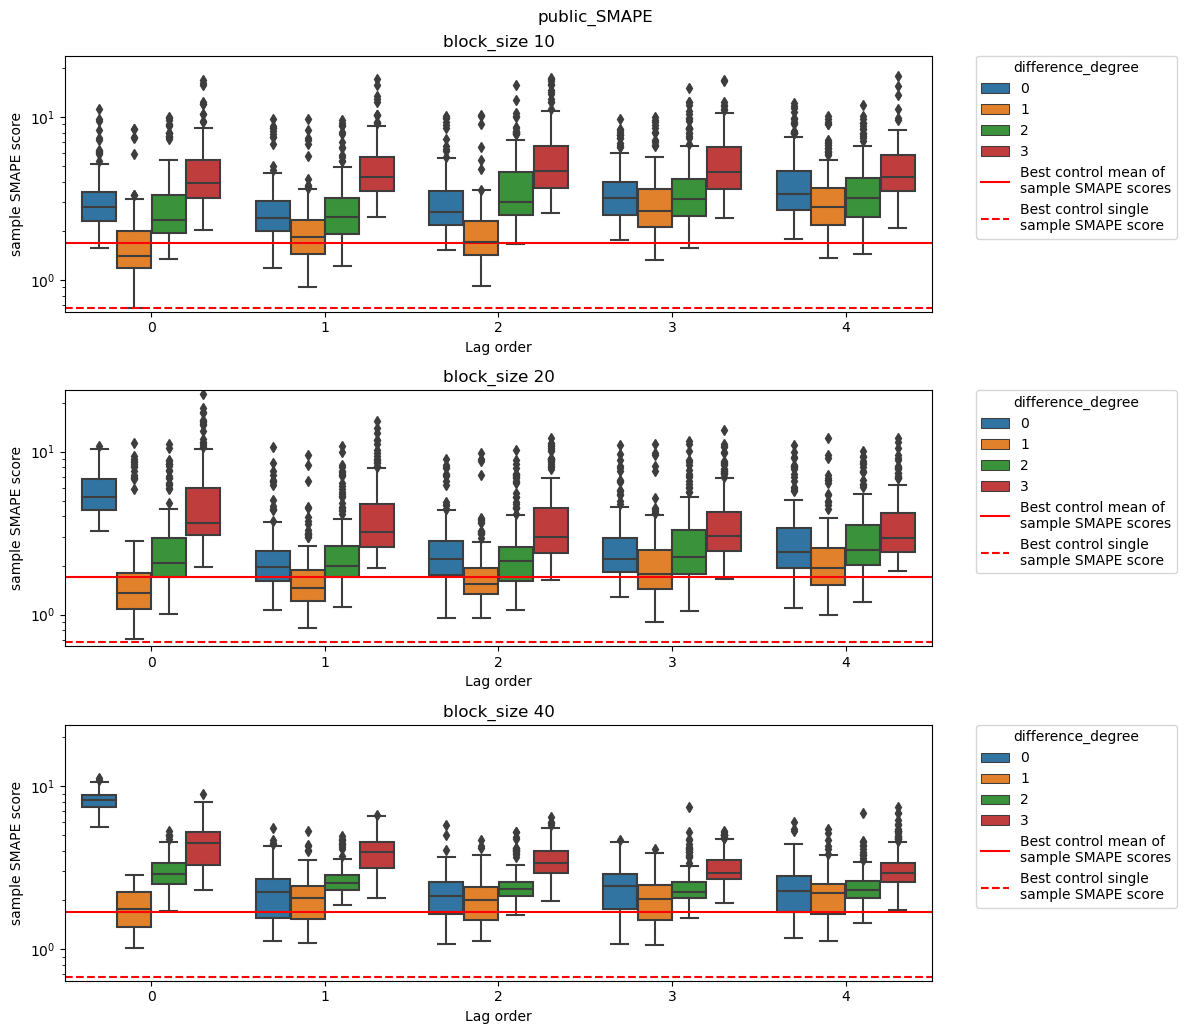

In [4]:

plt = funcs.sample_mean_smape_boxplot(
    sample_smape_scores_df,
    score_type = 'public_SMAPE',
    parameter = 'block_size',
    hue_by = 'difference_degree'
)


Winning control mean of sample SMAPE scores: 3.6585834137614253
Winning control single sample SMAPE score: 1.612679069237318

lag_order: [0, 1, 2, 3, 4]
difference_degree: [0, 1, 2, 3]
moving_average_order: [0]
block_size: [10, 20, 40]



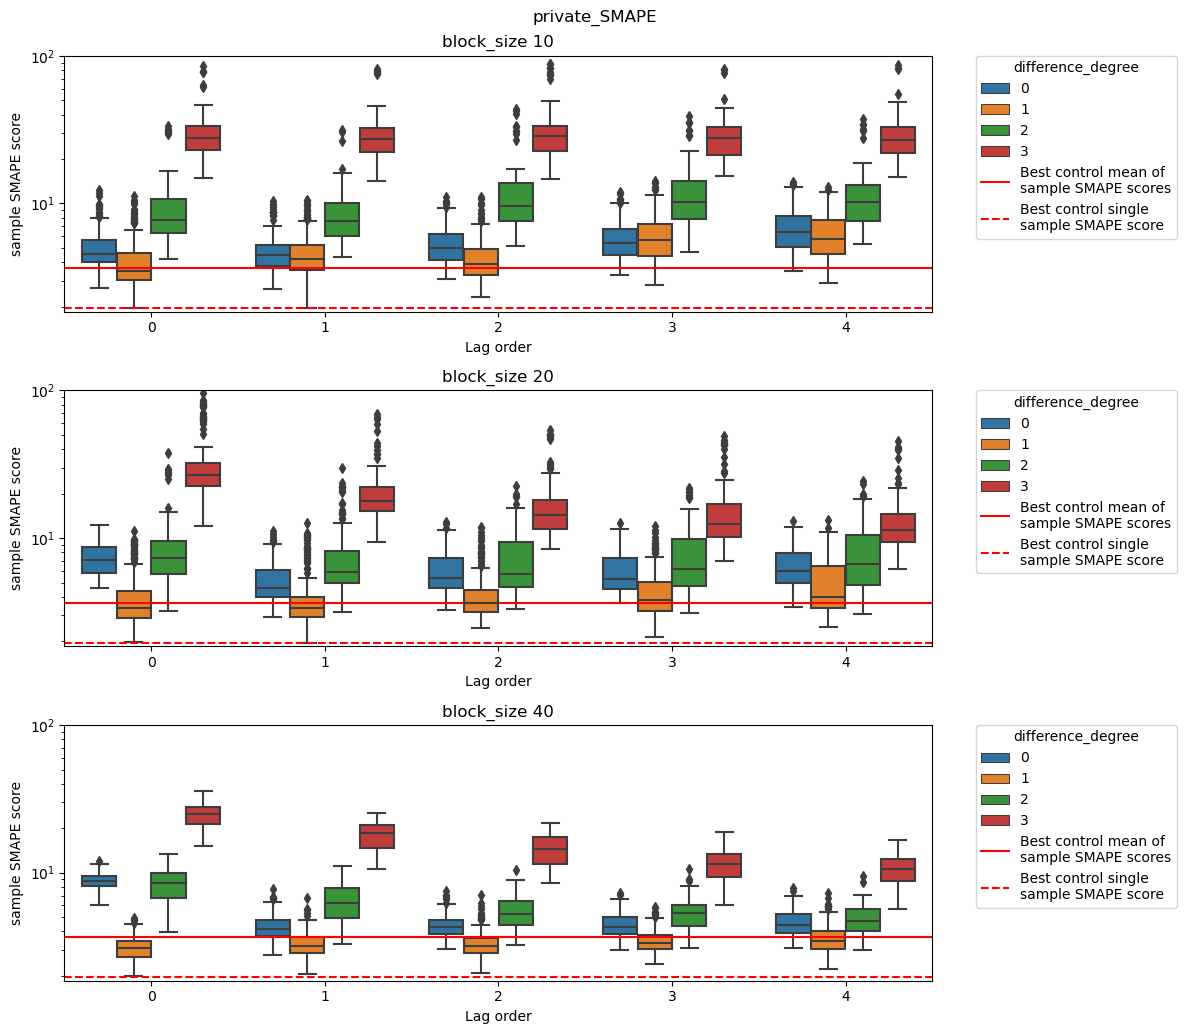

In [5]:

plt = funcs.sample_mean_smape_boxplot(
    sample_smape_scores_df,
    score_type = 'private_SMAPE',
    parameter = 'block_size',
    hue_by = 'difference_degree'
)

<a name="moving_average"></a>
### 2. Experiment 2: Moving average order by lag order and difference degree

In [6]:
sample_smape_scores_df = funcs.parse_results(
    input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}-moving_average_order.parquet'
)

sample_smape_scores_df.head(3)

,sample,model_type,block_size,lag_order,difference_degree,moving_average_order,public_SMAPE,private_SMAPE,log_public_SMAPE,log_private_SMAPE
0,0,ARIMA,10,0,1,0,2.093895,3.660141,0.739026,1.297502
1,0,ARIMA,10,0,1,1,2.026052,4.593844,0.706089,1.524717
2,0,ARIMA,10,0,1,2,1.307854,4.909393,0.268388,1.591150



Winning control mean of sample SMAPE scores: 1.6904793939878409
Winning control single sample SMAPE score: 0.6096220677126482

lag_order: [0]
difference_degree: [1]
moving_average_order: [0, 1, 2, 3, 4, 5]
block_size: [10, 20, 40]



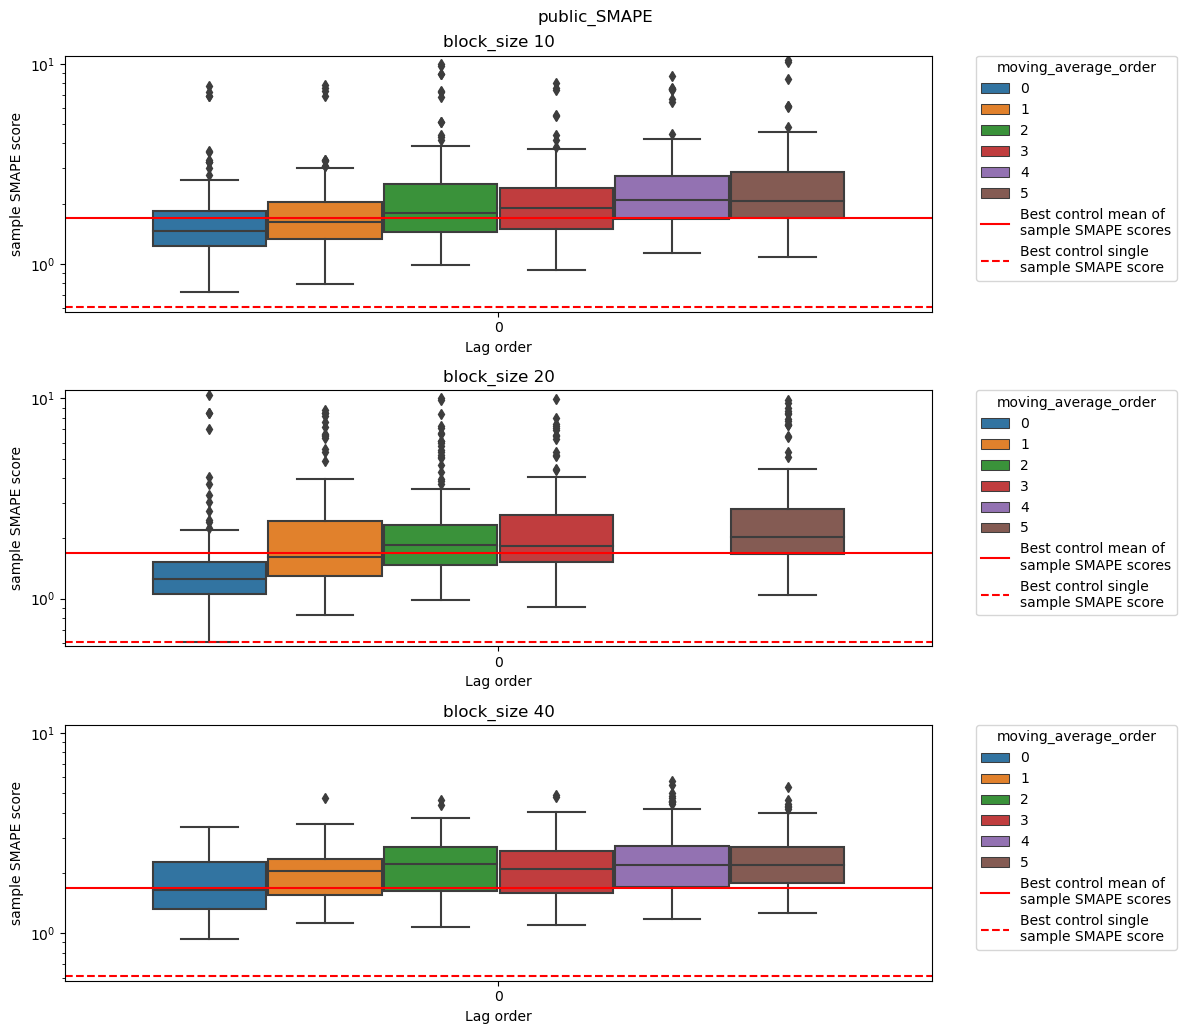

In [8]:
plt = funcs.sample_mean_smape_boxplot(
    sample_smape_scores_df,
    score_type = 'public_SMAPE',
    parameter = 'block_size',
    hue_by = 'moving_average_order'
)


Winning control mean of sample SMAPE scores: 3.7855794993270346
Winning control single sample SMAPE score: 1.8051509702771176

lag_order: [0]
difference_degree: [1]
moving_average_order: [0, 1, 2, 3, 4, 5]
block_size: [10, 20, 40]



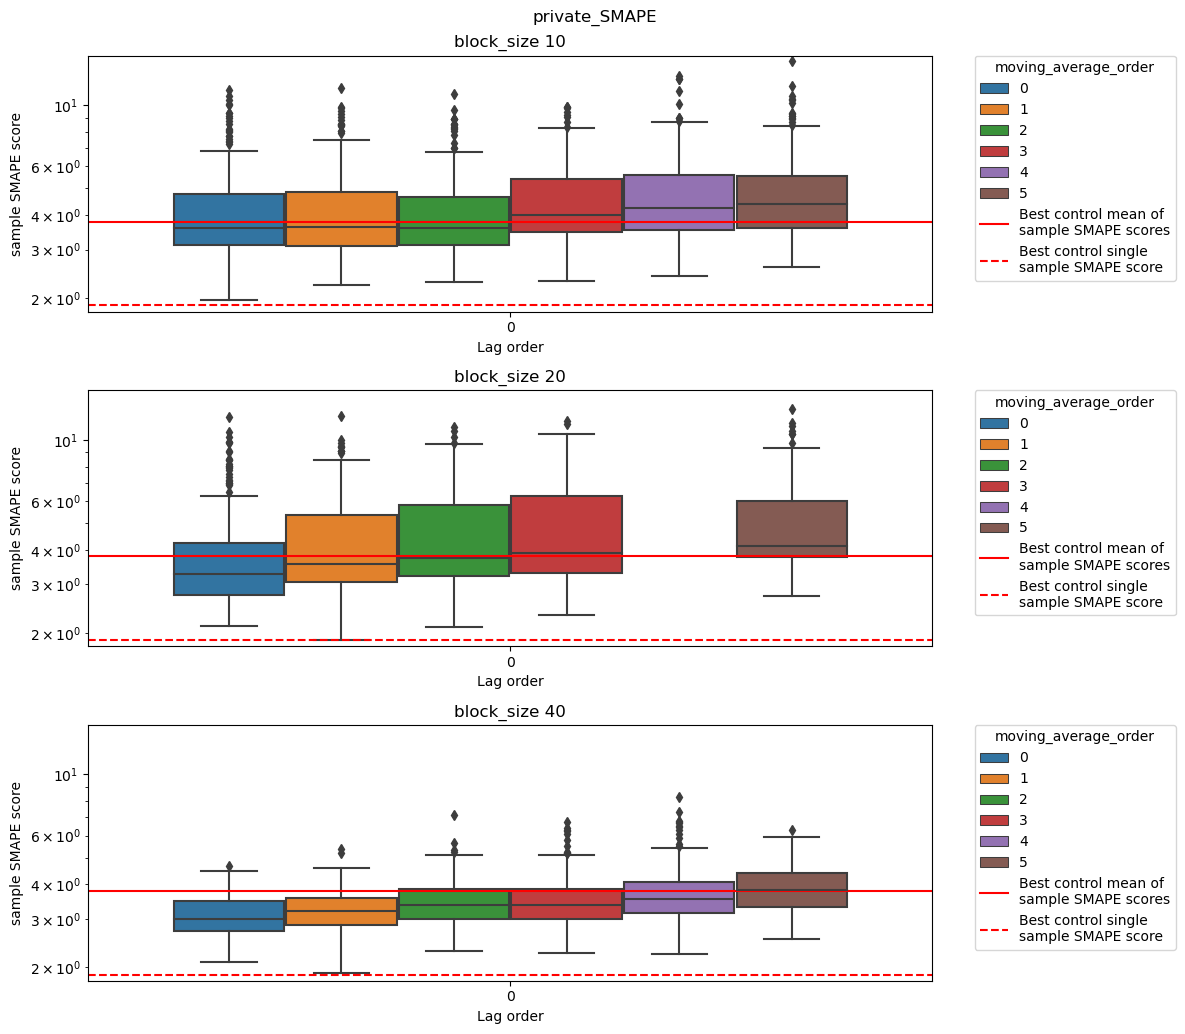

In [9]:
plt = funcs.sample_mean_smape_boxplot(
    sample_smape_scores_df,
    score_type = 'private_SMAPE',
    parameter = 'block_size',
    hue_by = 'moving_average_order'
)

* **Public SMAPE winner**: Block size 20, lag order 0, difference degree 1, moving average order 0
* **Private SMAPE winner**: Block size 40, lag order 0, difference degree 1, moving average order 0

<a name="winner"></a>
### 3. Experiment 3: winning parameters, large sample

In [ ]:
sample_smape_scores_df = funcs.parse_results(
    input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}-winning_parameters.parquet'
)

sample_smape_scores_df.head(3)

In [ ]:
sns.kdeplot(data=sample_smape_scores_df, x='SMAPE_score', hue='model_type')